## Multilabel with Segmentation U-Net, FCN & Mask RCNN

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

,Filename,Label
0,image_1.jpg,"[Kerbau,Manusia]"
1,image_10.jpg,"[Kerbau,Manusia]"
2,image_100.jpg,[Kerbau]
3,image_101.jpg,"[Kerbau,Manusia]"
4,image_102.jpg,"[Kerbau,Manusia]"
...,...,...
2110,image_1999.jpg,"[Kerbau,Manusia,Truk]"
2111,image_2.jpg,"[Kerbau,Manusia]"
2112,image_20.jpg,"[Kerbau,Manusia]"
2113,image_200.jpg,[Kerbau]


In [3]:
df.isna().sum()

Filename    0
Label       0
dtype: int64

In [4]:
df['Filename'] = "data/image/" + df["Filename"]

In [5]:
df.isna().sum()

Filename    0
Label       0
dtype: int64

<Axes: xlabel='Label'>

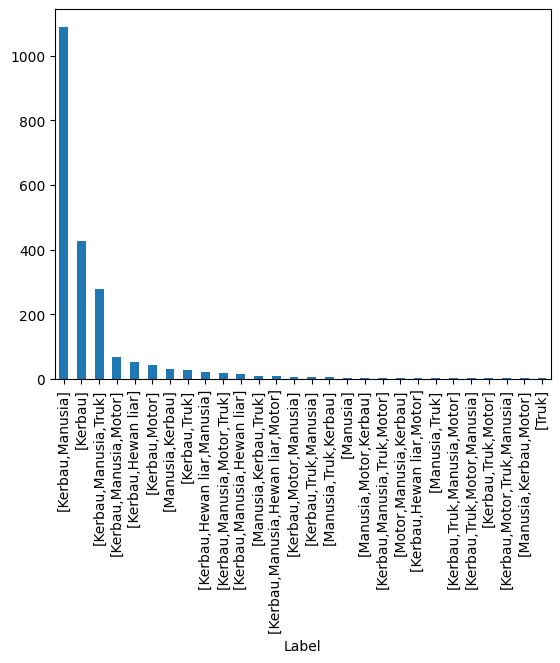

In [6]:
df['Label'].value_counts().plot(kind='bar')

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

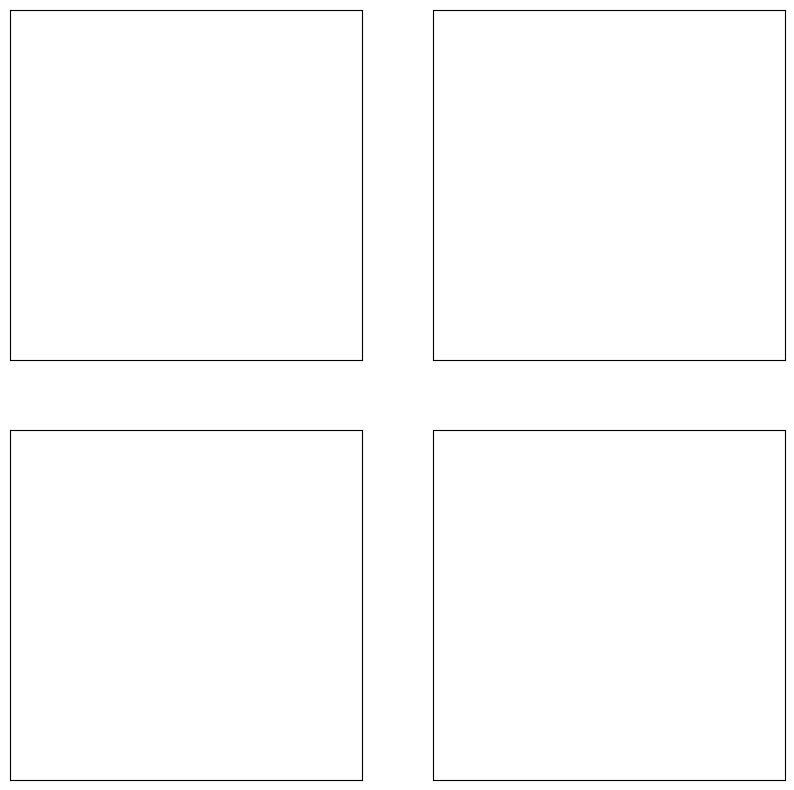

In [19]:
random_index = np.random.randint(0, len(df), 10)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i in enumerate(ax.flat):
    ax.imshow(plt.imread(df.Filename[random_index]))
plt.show()

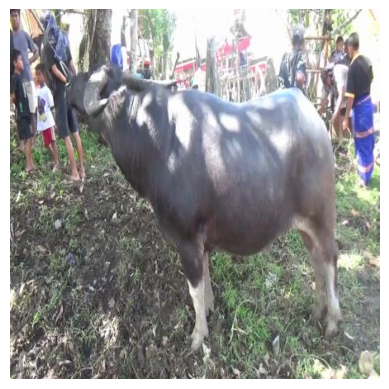

In [8]:
vis_img(df["Filename"][1])

In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
train.isna().sum()

Filename    0
Label       0
dtype: int64

In [11]:
datagen = ImageDataGenerator(rescale=1./255.0)
test_datagen = ImageDataGenerator(rescale=1./255.0)

train_gen = datagen.flow_from_dataframe(
    train,
    x_col ='Filename',
    y_col ='Label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = "categorical",
    classes = ['Kerbau', 'Manusia', 'Hewan liar', 'Motor', "Truk"],
    target_size = (448, 448)
)

test_gen = test_datagen.flow_from_dataframe(
    test,
    x_col ='Filename',
    y_col ='Label',
    batch_size = 1,
    # seed = 42,
    # shuffle = True,
    class_mode = "categorical",
    classes = ['Kerbau', 'Manusia', 'Hewan liar', 'Motor', "Truk"],
    target_size = (448, 448)
)

Found 0 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 5 classes.


In [12]:
filename = train_gen.filenames
filename

[]

# U-Net

Berikut arsitektur keseluruhan U-Net yang akan digunakan:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

UNet terdiri dari encoder (downsampler) dan decoder (upsampler) dengan hambatan di antaranya. Panah abu-abu sesuai dengan koneksi lompatan yang menggabungkan output blok encoder ke setiap tahap decoder.

### Encoder
Block-block encoder berisi 2 layer Conv2D diakttifkan oleh relu, serta di ikuti oleh MaxpPooling dan Dropout

In [ ]:
def conv2d_block(input_tensor, n_filter, kernel_size=3):
    ''' 
    Arg:
    input_tensor (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    kernel_size (int) -- ukuran kernel untuk konvolusi

    return
    tensor dari fitur keluaran
    '''
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding='same')(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filter, pool_size=2, dropout=0.3):
    '''
    Arg:
    input (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    pool_size - ukuran pool size
    dropout - jumlah yang ingin di dropout/buang

    return
    f - fitur keluaran dari block conv
    p - fitur yang dikumpulkan di MaxPooling dengan DropOut
    '''
    f = conv2d_block(inputs, n_filter)
    p = tf.keras.layers.MaxPooling2D((pool_size, pool_size))(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

def encoder(inputs):
    '''
    Arg:
    inputs - masukkan gambar

    return
    p4 - fitur yang dikumpulkan dari keseluruhan encoder block
    (f1, f2, f3, f4) - fitur yang dikeluarkan dari semua encoder block
    '''
    f1, p1 = encoder_block(inputs, n_filter=64)
    f2, p2 = encoder_block(p1, n_filter=128)
    f3, p3 = encoder_block(p2, n_filter=256)
    f4, p4 = encoder_block(p3, n_filter=512)
    return p4, (f1, f2, f3, f4)


### Bottleneck
Sebuah bottleneck mengikuti blok encoder dan digunakan untuk mengekstrak lebih banyak fitur. Ini tidak memiliki lapisan penyatuan sehingga dimensinya tetap sama.

In [ ]:
def bottleneck(inputs):

    x = conv2d_block(input_tensor=inputs, n_filter=1024)
    return x

### Decoder
 decoder yang meng-upsampling fitur kembali ke ukuran gambar asli. Pada setiap tingkat upsampling, akan mengambil output dari blok encoder yang sesuai dan menggabungkannya sebelum memasukkannya ke blok decoder berikutnya

In [ ]:
def decoder_block(inputs, conv_output, n_filter=64, kernel_size=3, strides=2, dropout=0.3):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    conv_output (tensor) - fitur dari blok encoder
    n_filter (int) -- jumlah filter
    kernel_size (int) -- ukuran kernel
    strides (int) -- langkah untuk dekonvolusi/upsampling
    padding (string) - "sama" atau "valid", memberi tahu apakah bentuk akan dipertahankan dengan padding nol

    return
    c (tensor) - fitur keluaran dari blok decoder
    '''
    u = tf.keras.layers.Conv2DTranspose(filters=n_filter, kernel_size=kernel_size, strides=strides, spadding='same')(inputs)
    c = tf.keras.layers.Concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filter=n_filter)

    return c

def decoder(inputs, convs, output_channels, activation):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    convs (tuple) -- fitur dari blok penyandi
    output_channels (int) -- jumlah kelas dalam peta label
    activation (softmax/sigmoid,etc) - aktifasi yang dipakai

    return
    output (tensor) -- peta label berdasarkan piksel dari gambar
    '''
    f1, f2, f3, f4 = convs

    c1 = decoder_block(inputs=inputs, conv_output=f4, n_filter=512)
    c2 = decoder_block(inputs=c1, conv_output=f3, n_filter=256)
    c3 = decoder_block(inputs=c2, conv_output=f2, n_filter=128)
    c4 = decoder_block(inputs=c3, conv_output=f1, n_filter=64)

    output =  tf.keras.layers.Conv2D(output_channels, (1, 1), activation=activation)(c4)
    return output

In [ ]:
def unet(input_shape, output, activation):
    '''
    Mendefinisikan UNet dengan menghubungkan encoder, bottleneck, dan decoder.

    args:
    input_shape (int)- besaran deminsi input
    output (int) - jumlah output yang dikeluarkna
    activation - aktifasi yang digunakan untuk klasifikasi
    '''

    input = tf.keras.layers.Input(shape=input_shape)
    encoder_output, convs = encoder(input)
    bottleneck = bottleneck(encoder_output)
    outputs = decoder(bottleneck, convs=convs, output_channels=output, activation=activation)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    return model